In [1]:
import sys
sys.path.append("/home/bl9/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

#import geobayes_simple as gs
from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

#import seaborn
#seaborn.set_context(font_scale=2)
#seaborn.set_style("white")

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

import copy

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

from gempy import Topology

import vtk

In [3]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 50,50,50],
                         path_f = "/home/bl9/gempy//input_data/FabLessPoints_Foliations.csv",
                         path_i = "/home/bl9/gempy//input_data/FabLessPoints_Points.csv")
geo_data.n_faults = 1

In [16]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Reservoir', 'Seal', 'NonReservoirDeep','SecondaryReservoir')},
                       order_series = ["fault",
                                       "Rest",
                                       ], verbose=0)

In [17]:
geo_data.set_formation_number(['MainFault', 'SecondaryReservoir', 'Seal', 
                               'Reservoir','NonReservoirDeep'])

In [18]:
gp.data_to_pickle(geo_data, 'BasicFault')

In [19]:
# stdev for x,y,z interface coordinates
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = None
geo_data.interfaces['Z_std'] = None
geo_data.interfaces['dist_type'] = "Normal" # should be initially None
geo_data.interfaces['X_dist'] = None
geo_data.interfaces['Y_dist'] = None
geo_data.interfaces['Z_dist'] = None

In [20]:
geo_data.interfaces.head()

X       Y       Z  formation series  order_series  formation number  \
0  1000.0  1000.0 -1000.0  MainFault  fault             1                 1   
1   800.0  1000.0 -1600.0  MainFault  fault             1                 1   
2  1200.0  1000.0  -400.0  MainFault  fault             1                 1   
3  1100.0  1000.0  -700.0  MainFault  fault             1                 1   
4   900.0  1000.0 -1300.0  MainFault  fault             1                 1   

                        annotations  isFault X_std Y_std Z_std dist_type  \
0  ${\bf{x}}_{\alpha \,{\bf{4}},0}$     True  None  None  None    Normal   
1  ${\bf{x}}_{\alpha \,{\bf{4}},4}$     True  None  None  None    Normal   
2  ${\bf{x}}_{\alpha \,{\bf{4}},3}$     True  None  None  None    Normal   
3  ${\bf{x}}_{\alpha \,{\bf{4}},2}$     True  None  None  None    Normal   
4  ${\bf{x}}_{\alpha \,{\bf{4}},1}$     True  None  None  None    Normal   

  X_dist Y_dist Z_dist  
0   None   None   None  
1   None   None   None  
2   None   None   None  
3   None   None   None  
4   None   None   None

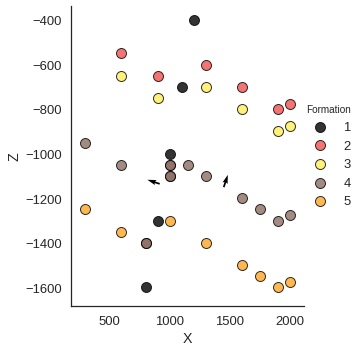

In [21]:
gp.plot_data(geo_data)

In [77]:
gp.plot_data_3D(geo_data)

917.45 1000.0 -1135.398
917.45 1000.0 -1135.398
917.45 1000.0 -1135.398
917.45 1000.0 -1135.398
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0


In [22]:
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

In [23]:
sol, pot = gp.compute_model(interp_data, get_potential_at_interfaces=True)
sol.shape

(1, 3, 125000)

In [24]:
res_surf, res_surf_simp = gp.get_surfaces(potential_block=sol[0,1,:], interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Reservoir']))

lith = sol[0, 0,:]
fault = sol[0, 2,:]

In [25]:
nonresdeep_surf, nonresdeep_surf_simp = gp.get_surfaces(potential_block=sol[0,1,:], interp_data = interp_data, n_formation = (interp_data.get_formation_number()['NonReservoirDeep']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(potential_block=sol[0,1,:], interp_data = interp_data, n_formation = (interp_data.get_formation_number()['SecondaryReservoir']))
seal_surf, seal_surf_simp = gp.get_surfaces(potential_block=sol[0,1,:], interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Seal']))

In [18]:
geo_data.get_formation_number().keys()

dict_keys(['SecondaryReservoir', 'MainFault', 'NonReservoirDeep', 'DefaultBasement', 'Seal', 'Reservoir'])

In [19]:
geo_data.get_formations()

array(['MainFault', 'NonReservoirDeep', 'Reservoir', 'SecondaryReservoir',
       'Seal'], dtype=object)

In [20]:
geo_data.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'NonReservoirDeep': 5,
 'Reservoir': 4,
 'Seal': 3,
 'SecondaryReservoir': 2}

In [109]:
gp.plot_surfaces_3D(geo_data, [sec_res_surf, seal_surf, res_surf, nonresdeep_surf], 
                    [sec_res_surf_simp, seal_surf_simp, res_surf_simp, nonresdeep_surf_simp], 
                    ["SecondaryReservoir", "Seal", 'Reservoir', "NonReservoirDeep"], [1,2,3,4])

917.45 1000.0 -1135.398
917.45 1000.0 -1135.398
917.45 1000.0 -1135.398
917.45 1000.0 -1135.398
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0


In [46]:
gp.plot_surfaces_3D(geo_data, [res_surf], 
                    [res_surf_simp], 
                    ['Reservoir'], [3])

917.45 1000.0 -1135.398
917.45 1000.0 -1135.398
917.45 1000.0 -1135.398
917.45 1000.0 -1135.398
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0


In [193]:
np.set_printoptions(threshold=np.nan)
#(position res_surf[1,:])
#print(res_sorted)
#sol[0,:].reshape(50,50,50)

In [36]:
interp_data.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'NonReservoirDeep': 5,
 'Reservoir': 4,
 'Seal': 3,
 'SecondaryReservoir': 2}

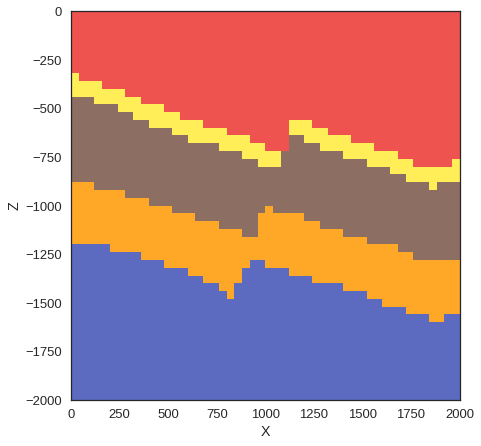

In [94]:
#%matplotlib notebook
%matplotlib inline
gp.plot_section(geo_data, sol[0,0,:], 25) #plot_data=True)

In [23]:
interp_data.geo_data_res.n_faults

1

In [24]:
interp_data.geo_data_res.interfaces

X         Y         Z           formation series  order_series  \
0   0.461638    0.5001    0.5001           MainFault  fault             1   
1   0.410356    0.5001  0.346254           MainFault  fault             1   
2   0.512921    0.5001  0.653946           MainFault  fault             1   
3   0.487279    0.5001  0.577023           MainFault  fault             1   
4   0.435997    0.5001  0.423177           MainFault  fault             1   
5   0.718049    0.5001  0.557792  SecondaryReservoir   Rest             2   
6   0.615485    0.5001  0.577023  SecondaryReservoir   Rest             2   
7   0.692408    0.5001  0.551382  SecondaryReservoir   Rest             2   
8   0.435997    0.5001  0.589844  SecondaryReservoir   Rest             2   
9   0.359074    0.5001  0.615485  SecondaryReservoir   Rest             2   
10  0.538562    0.5001  0.602664  SecondaryReservoir   Rest             2   
11  0.435997    0.5001  0.564203                Seal   Rest             2   
12  0.692408    0.5001  0.525741                Seal   Rest             2   
13  0.718049    0.5001  0.532151                Seal   Rest             2   
14  0.359074    0.5001  0.589844                Seal   Rest             2   
15  0.538562    0.5001  0.577023                Seal   Rest             2   
16  0.615485    0.5001  0.551382                Seal   Rest             2   
17  0.410356  0.294972  0.397536           Reservoir   Rest             2   
18  0.410356  0.705228  0.397536           Reservoir   Rest             2   
19  0.359074    0.5001  0.487279           Reservoir   Rest             2   
20  0.282151    0.5001  0.512921           Reservoir   Rest             2   
21  0.718049    0.5001  0.429587           Reservoir   Rest             2   
22  0.692408    0.5001  0.423177           Reservoir   Rest             2   
23  0.538562    0.5001  0.474459           Reservoir   Rest             2   
24  0.615485    0.5001  0.448818           Reservoir   Rest             2   
25  0.653946    0.5001  0.435997           Reservoir   Rest             2   
26  0.461638  0.269331  0.474459           Reservoir   Rest             2   
27  0.461638    0.7501  0.487279           Reservoir   Rest             2   
28  0.461638  0.730869  0.474459           Reservoir   Rest             2   
29    0.5001    0.5001  0.487279           Reservoir   Rest             2   
30  0.461638    0.2501  0.487279           Reservoir   Rest             2   
31  0.282151    0.5001  0.435997    NonReservoirDeep   Rest             2   
32  0.718049    0.5001  0.352664    NonReservoirDeep   Rest             2   
33  0.538562    0.5001  0.397536    NonReservoirDeep   Rest             2   
34  0.615485    0.5001  0.371895    NonReservoirDeep   Rest             2   
35  0.653946    0.5001  0.359074    NonReservoirDeep   Rest             2   
36  0.461638    0.5001  0.423177    NonReservoirDeep   Rest             2   
37  0.359074    0.5001  0.410356    NonReservoirDeep   Rest             2   
38  0.692408    0.5001  0.346254    NonReservoirDeep   Rest             2   

    formation number                        annotations  isFault X_std Y_std  \
0                  1   ${\bf{x}}_{\alpha \,{\bf{4}},0}$     True   NaN   NaN   
1                  1   ${\bf{x}}_{\alpha \,{\bf{4}},4}$     True   NaN   NaN   
2                  1   ${\bf{x}}_{\alpha \,{\bf{4}},3}$     True   NaN   NaN   
3                  1   ${\bf{x}}_{\alpha \,{\bf{4}},2}$     True   NaN   NaN   
4                  1   ${\bf{x}}_{\alpha \,{\bf{4}},1}$     True   NaN   NaN   
5                  2   ${\bf{x}}_{\alpha \,{\bf{5}},0}$    False   NaN   NaN   
6                  2   ${\bf{x}}_{\alpha \,{\bf{5}},1}$    False   NaN   NaN   
7                  2   ${\bf{x}}_{\alpha \,{\bf{5}},2}$    False   NaN   NaN   
8                  2   ${\bf{x}}_{\alpha \,{\bf{5}},3}$    False   NaN   NaN   
9                  2   ${\bf{x}}_{\alpha \,{\bf{5}},4}$    False   NaN   NaN   
10                 2   ${\bf{x}}_{\alpha \,{\bf{5}

In [9]:
resolution = 50
model_size = 2000
scale_factor = (model_size/resolution) #original grid in [m]/grid resolution --> what if model not cubic?

In [198]:
# Finding spill and leak point

def spill_point(res_surface):
    mini = argrelextrema(res_surface[:,2], np.less, order=10)
    minima = np.array(list(zip(np.take(res_surface[:,1], mini[0]), np.take(res_surface[:,0], mini[0]), np.take(res_surface[:,2], mini[0]))))
    fault_thresh = minima[:,1] > 700 #taking only relevant side by setting a threshold visually estimated, best: 20
    spill_line = minima[fault_thresh]
    spill_pos = np.array(np.argmax(spill_line[:,2]))
    spill_z = np.take(spill_line[:,2], spill_pos)
    spill_p = np.array([np.take(spill_line[:,1], spill_pos), np.take(spill_line[:,0], spill_pos), np.take(spill_line[:,2], spill_pos)])
    
    spill_bottom = np.ones_like(res_surface)
    spill_bottom[:,0] = res_surface[:,0]
    spill_bottom[:,1] = res_surface[:,1]
    spill_bottom[:,2] = spill_z    
    
    return spill_z, spill_p, spill_line, spill_bottom

def leak_point(res_surface):
    counter = 0
    #creating empty lists and arrays to save values
    xvals = []
    yvals = []
    zvals = []
    leak_min = np.empty([3,], dtype=int)
    
    while counter < model_size:
        #print(counter)
        for e in res_surface:
            #looking at a slice along y-axis for y = e[1] = counter, 
            #and appending x,y,z-values into lists
            if int(e[1]) == counter:
                xvals.append(e[0])
                yvals.append(e[1])
                zvals.append(e[2])
            
        #saving x,y,z-values as lists/arrays      
        zvals = np.array(zvals)
        yvals = np.array(yvals)
        xvals = np.array(xvals)
        #print('x',xvals)
        #print('y',yvals)
        #print('z',zvals)
        
        #looking fore minima positions in z-array
        min_pos = argrelextrema(zvals, np.less, order=10)
        
        #saving x,y,z-positions of minima
        ypos = yvals[min_pos]
        xpos = xvals[min_pos]
        mins = zvals[min_pos]
        
        #condition: check if any minimum was found and if any data is given at y = counter
        #if no minima found, restart loop at next iteration
        if len(mins) == 0:
            counter += 1
            #lists have to be emptied again
            xvals = []
            yvals = []
            zvals = []
            continue
        
        #np.append(leak_min, mins) -----> what did I use this for???
        
        #create and array element to save coordinates of minima
        mins_pos = np.array(list(zip(xpos, ypos, mins)))
        #save minima of slice into array of ALL minima
        leak_min = np.vstack((leak_min, mins_pos))

        #empty lists for next iteration
        xvals = []
        yvals = []
        zvals = []
    
        counter += 1
        
    leak_min = np.delete(leak_min, 0, 0) #what does this do???
    
    #result of the loop above is one or SEVERAL lines of minima ("leak lines")
    #only want to look at the line bordering the fault surface
    #need for a general function/method to limit to only that line!
    
    near_fault_thresh = leak_min[:,0] < 1500 #taking only relevant side by setting a threshold visually estimated, best: 20
    leak_line = leak_min[near_fault_thresh]
    
    leak_pos = np.array(np.argmax(leak_line[:,2]))
    leak_z = np.take(leak_line[:,2], leak_pos)

    leak_p = np.array([np.take(leak_line[:,1], leak_pos), np.take(leak_line[:,0], leak_pos), np.take(leak_line[:,2], leak_pos)])
    
    leak_bottom = np.ones_like(res_surface)
    leak_bottom[:,0] = res_surface[:,0]
    leak_bottom[:,1] = res_surface[:,1]
    leak_bottom[:,2] = leak_z
   
    return leak_z, leak_p, leak_line, leak_bottom

# Calculation of maximal reservoir volume
def max_res_vol(lith, fault, res_surface):
    #calculate spill point
    spill_z, spill_p, spill_line, spill_bottom = spill_point(res_surface)
    #calculate leak point
    leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
    
    #check for "down-to" z horizon, maximum depth of reservoir
    max_z = np.max([spill_z, leak_z])
    
    #"bottom" as horizontal surface at max_z
    
    if max_z == spill_z:
        print("Down to spill.")
        bottom_surface = spill_bottom
    else:
        print("Down to leak.")
        bottom_surface = leak_bottom
    
    #print('Max_Z:', max_z)
    
    res_nr = lith == 5 #interp_data.get_formation_number()['Reservoir']
    trap = trap_mask(lith, fault, max_z, res_nr)
    
    lith = set_spill_to_seal(geo_data, lith, max_z)
        
    #counting reservoir cells
    vol_cells = 0
    
    for i in range(lith.shape[0]):
        if trap[i] == True:
            lith[i] = 7
            vol_cells +=1          
    
    #calulate volume from cells
    res_vol = ((scale_factor)**3) * vol_cells
    
    #return the maximum reservoir volume
    return res_vol, lith, bottom_surface

# Masking function that confines trap volume
def trap_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = bottom_z/scale_factor
    mask = mask.reshape(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(125000,)
    return mask

def footwall_mask(lith, fault):
    mask = np.ones_like(lith)
    mask[fault.astype(bool)] = False
    return mask

# Function that sets all voxels of lith_block which are equal (or closest to) to the spill_z
# horizontal as belonging to the overlying seal 
# (the voxels is located on the border of reservoir and seal):
def set_spill_to_seal(geo_data, lith, max_z):
    lith_spill = np.argmin(np.abs(geo_data.grid.grid[:, 2]+np.abs(max_z)))
    bol_lith_spill = geo_data.grid.grid[:, 2] == geo_data.grid.grid[:, 2][lith_spill]
    lith[bol_lith_spill] = 6
    return lith

def topo_analysis(lith, fault):
    trap_section = 0
    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    topo = Topology.Topology(lith_pad, fault_pad)
    topo.draw_section(25)
    topo_keys = [int(k) for k in topo.lith_to_labels_lot["7"].keys()]
    pad_keys = [int(p) for p in topo.lith_to_labels_lot["8"].keys()]
    for tk in topo_keys:        
        if topo.check_adjacency(tk, pad_keys[0]) == False:
            print("TRAAAAAAAAAAAAAAAAAP!!!!", tk)
            trap_section = tk
            
    print(topo.block, topo.n_labels, np.unique(topo.ublock))
    topo_block = topo.block
    top_bol = topo_block == trap_section
    topo_block[top_bol] = True
    topo_block[~top_bol] = False
    
    #topo_block = topo.ublock.reshape(140608)
    #
    #for i in topo_block:
    #    if topo_block[i] == trap_section:
    #        topo_block[i] = 1
    #    else:
    #        topo_block[i] = 0
    #print(topo_block)
    #
    #topo_masked = topo_block.reshape(52,52,52)
    
    plt.imshow(topo_block[:,25,:].T, origin="lower")
            
            
#def pad_block(block):
#    padded_block = (np.pad(block.reshape(50,50,50), 1, 'constant'))
#    return padded_block

In [12]:
#Visualization of spill and leak points
def plot_spill(res_surface, spill_line, spill_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_line[:,0], -spill_line[:,1], spill_line[:,2], c='r', s = 100)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 1000)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

def plot_leak(res_surface, leak_line, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-leak_line[:,1], -leak_line[:,0], leak_line[:,2], c='r', s = 100)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 1000)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    
def plot_trap(res_surface, bottom_surface, spill_p, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-bottom_surface[:,1], -bottom_surface[:,0], bottom_surface[:,2], c="r", alpha = 0.05)
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 1000)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 1000)

    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    

In [27]:
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'NonReservoirDeep']['Z']

res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'])

In [103]:
z_sec_res_top = pymc.Normal('z_unc_sec_res', 0, 1./0.0001)
z_seal_top = pymc.Normal('z_unc_seal', 0, 1./0.0005)
z_res_top = pymc.Normal('z_unc_res', 0, 1./0.001)
z_base_top = pymc.Normal('z_unc_base', 0, 1./0.05)

variation: -0.02347552360220792


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Spill_Z: -1231.41845703
Leak_Z: -1277.32620239


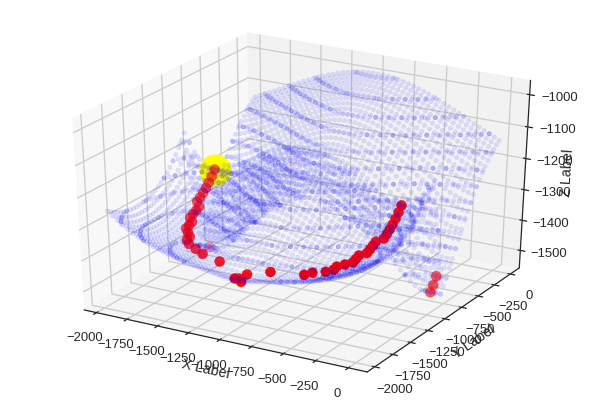

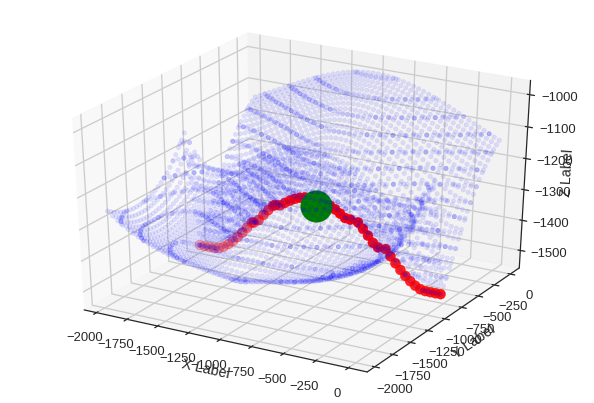

Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:145: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


TRAAAAAAAAAAAAAAAAAP!!!! 16
[[[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
   8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
   8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
   8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
   8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
   8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
   8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
   8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
   8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
   8 8 8 

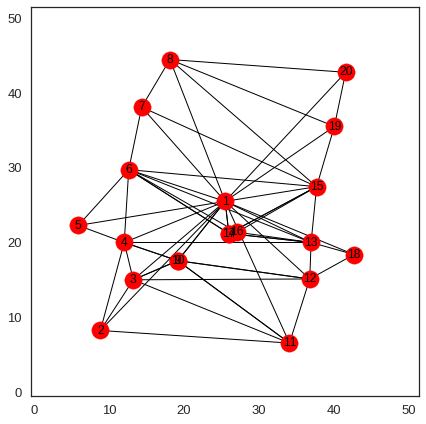

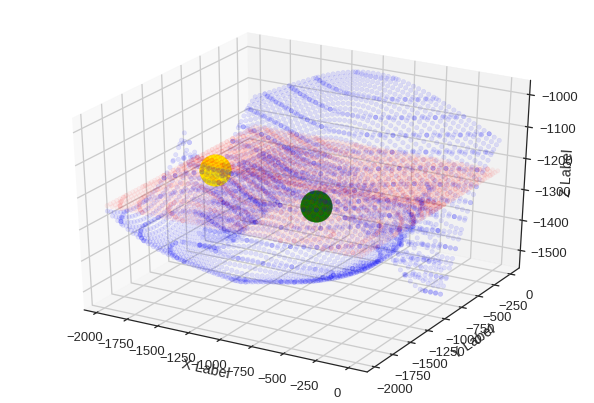

Bottom_Z: -1231.41845703
Maximum reservoir volume: 13824000.0 m³


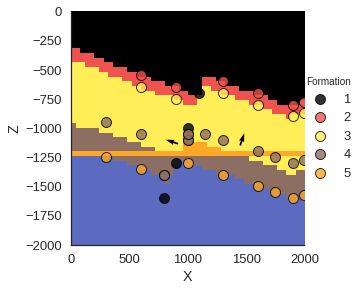

In [199]:
@pymc.deterministic
def gempy_model(value=0, z_res_top = z_res_top):

    new_z = res_z + z_res_top
    print('variation:', z_res_top)
    #print('new', new_z)
    #print(res_z)
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'] = new_z
    #print(interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'])
    
    sol, pot = gp.compute_model(interp_data, get_potential_at_interfaces=True)
    #gp.plot_section(geo_data, sol[0,:], 25)
    
    res_surf, res_surf_simp = gp.get_surfaces(potential_block=sol[0, 1,:], 
                                          interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Reservoir']),)
    
    #print(sol[1,:])
    lith_block = sol[0, 0,:]
    fault_block = sol[0, 2,:]
    
    spill_z, spill_p, spill_line, spill_bottom = spill_point(res_surf)
    leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surf)
    
    print('Spill_Z:', spill_z)
    print('Leak_Z:', leak_z)
    
    plot_spill(res_surf, spill_line, spill_p)
    plot_leak(res_surf, leak_line, leak_p)
            
    max_vol, sol[0, 0,:], bottom = max_res_vol(lith_block, fault_block, res_surf)
    
    #print(np.unique(sol[0, 0,:]))
    topo_analysis(sol[0, 0,:], fault_block)
    
    plot_trap(res_surf, bottom, spill_p, leak_p)
    print("Bottom_Z:", bottom[1,2])
    
    print("Maximum reservoir volume: %s m³" % max_vol)
    gp.plot_section(geo_data, sol[0, 0,:], 25, plot_data=1)
    return sol

In [77]:
topo.G.adj

{1: {2: {}, 6: {}},
 2: {1: {}, 3: {}, 6: {}, 7: {}},
 3: {2: {}, 4: {}, 7: {}, 8: {}},
 4: {3: {}, 5: {}, 8: {}},
 5: {4: {}, 8: {}, 9: {}, 10: {}},
 6: {1: {}, 2: {}, 7: {}},
 7: {2: {}, 3: {}, 6: {}, 8: {}},
 8: {3: {}, 4: {}, 5: {}, 7: {}, 9: {}},
 9: {5: {}, 8: {}, 10: {}},
 10: {5: {}, 9: {}}}

In [73]:
keys = [int(k) for k in topo.lith_to_labels_lot["5"].keys()]

In [74]:
keys

[2, 7]

In [138]:
topo.lith_to_labels_lot["5"]

TypeError: int() argument must be a string, a bytes-like object or a number, not 'dict'

In [72]:
topo.check_adjacency(keys[0], keys[1])

True

In [75]:
topo.labels_unique

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [78]:
topo.lithologies

array([0, 2, 3, 4, 5])

In [79]:
topo.n_labels

10

In [84]:
topo.ublock

array([[[6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8],
        ..., 
        [6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8]],

       [[6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8],
        ..., 
        [6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8]],

       [[6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8],
        ..., 
        [6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8],
        [6, 6, 6, ..., 8, 8, 8]],

       ..., 
       [[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ..., 
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2]],

       [[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ..., 
        [0, 0, 0, 

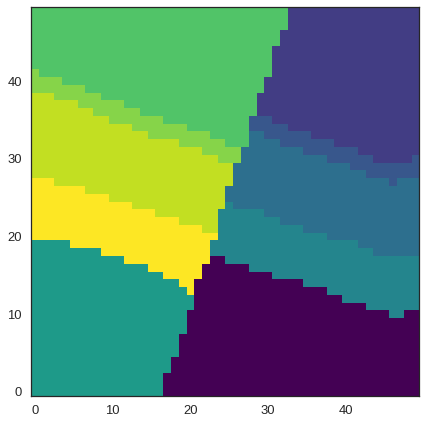

In [83]:
plt.imshow(topo.ublock[:,25,:].T, origin="lower", cmap="viridis")

In [179]:
topo

AttributeError: 'Topology' object has no attribute 'shape'

<IPython.core.display.Javascript object>


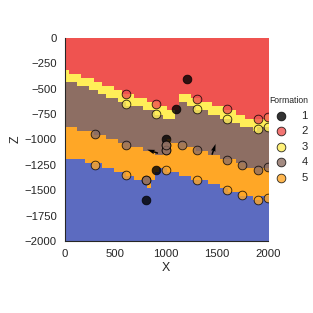

In [41]:
%matplotlib notebook
gp.plot_section(geo_data, sol[0, 0,:], 25, plot_data=1)

In [21]:
iterations = 5

In [22]:
model = pymc.Model([gempy_model, z_res_top])

variation: -0.014808984880906123
[3, 3]


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Spill_Z: -1334.34692383
Leak_Z: -1369.42592621


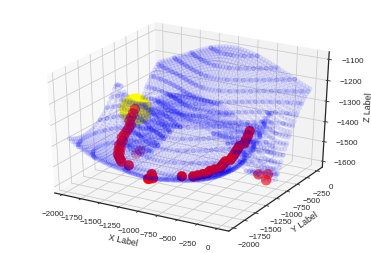

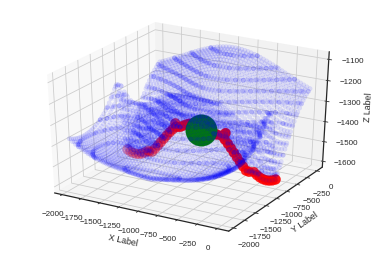

Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:143: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


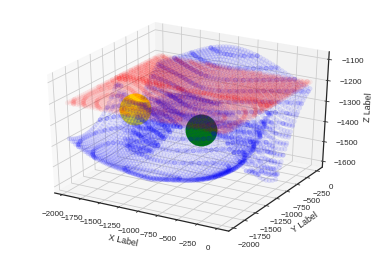

Bottom_Z: -1334.34692383
Maximum reservoir volume: 26368000.0 m³
 [---------------  40%                  ] 2 of 5 complete in 22.2 secvariation: 0.015001013659545086
[3, 3]
Spill_Z: -1216.16699219
Leak_Z: -1260.49507141


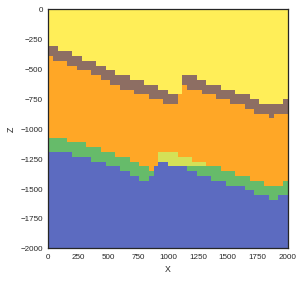

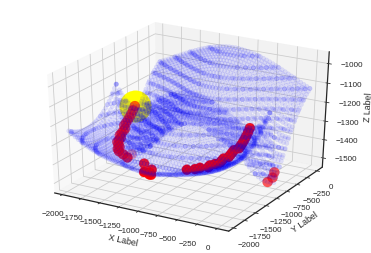

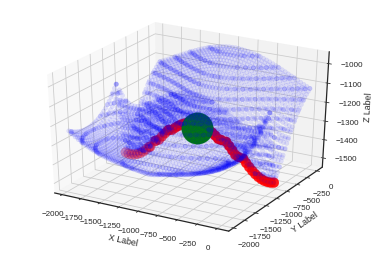

Down to spill.


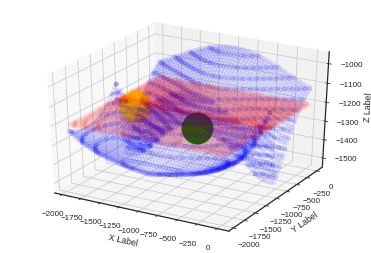

Bottom_Z: -1216.16699219
Maximum reservoir volume: 19968000.0 m³
 [-----------------60%--                ] 3 of 5 complete in 45.2 secvariation: 0.033728743945216515
[3, 3]
Spill_Z: -1157.2567749
Leak_Z: -1192.22511292


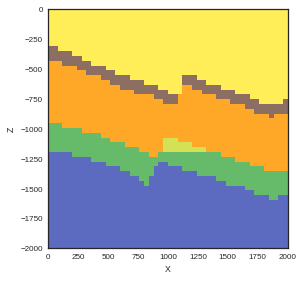

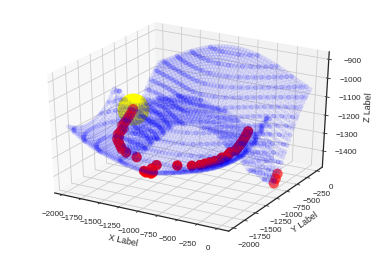

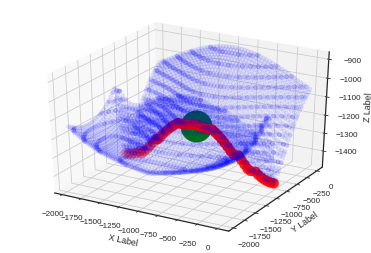

Down to spill.


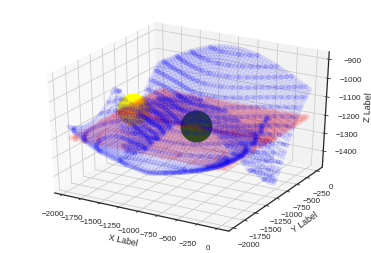

Bottom_Z: -1157.2567749
Maximum reservoir volume: 16896000.0 m³
 [-----------------80%----------        ] 4 of 5 complete in 68.6 secvariation: -0.004812136639273195
[3, 3]
Spill_Z: -1294.99725342
Leak_Z: -1328.7789917


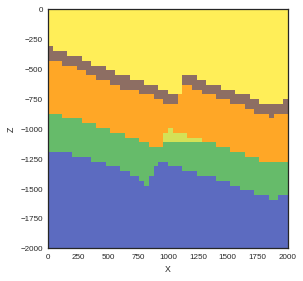

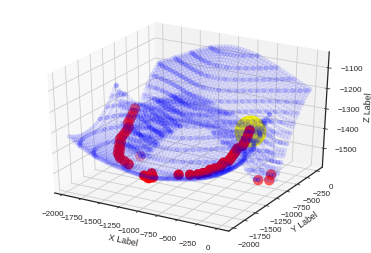

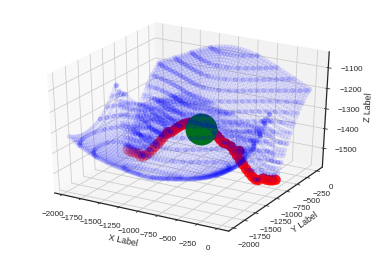

Down to spill.


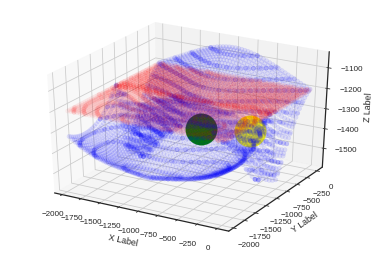

Bottom_Z: -1294.99725342
Maximum reservoir volume: 24960000.0 m³
 [-----------------100%-----------------] 5 of 5 complete in 91.1 secvariation: 0.042771574945129405
[3, 3]
Spill_Z: -1120.32791138
Leak_Z: -1152.90214539


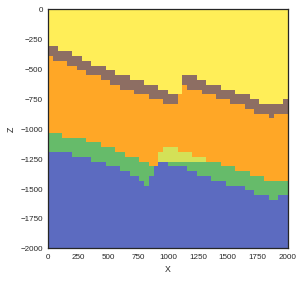

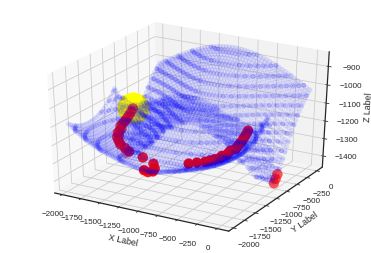

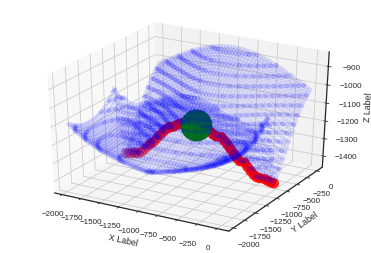

Down to spill.


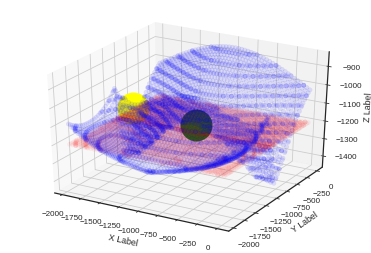

Bottom_Z: -1120.32791138
Maximum reservoir volume: 35584000.0 m³
 [--------------------120%---------------------] 6 of 5 complete in 114.1 sec

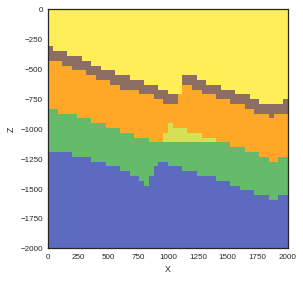

In [126]:
M = pymc.MCMC(model)
M.sample(iter=iterations)

-0.0148089848809
0.0150010136595
0.0337287439452
-0.00481213663927
0.0427715749451


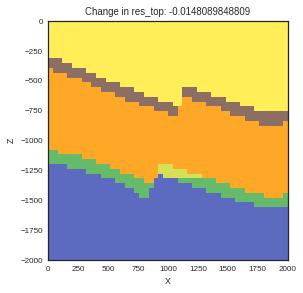

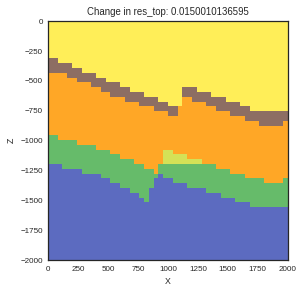

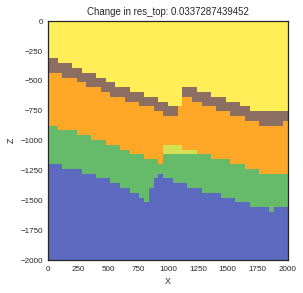

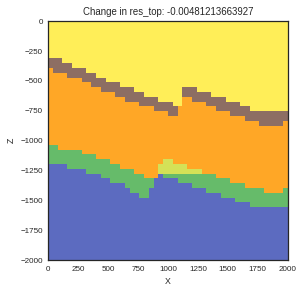

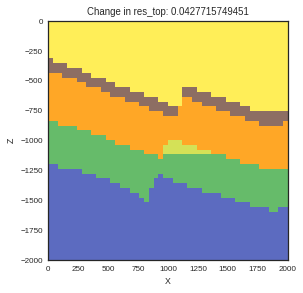

In [134]:
bla = M.trace('z_unc_res')[:]
bli = M.trace('gempy_model')[:]
bla.shape

for j in range(iterations):
    plt.figure()
    plt.title('Change in res_top: %s' % bla[j])
    print(bla[j])
    gp.plot_section(geo_data, bli[j,0], 20)

In [66]:
interp_data.geo_data_res.interfaces

X         Y         Z           formation series  order_series  \
0   0.461638    0.5001    0.5001           MainFault  fault             1   
1   0.410356    0.5001  0.346254           MainFault  fault             1   
2   0.512921    0.5001  0.653946           MainFault  fault             1   
3   0.487279    0.5001  0.577023           MainFault  fault             1   
4   0.435997    0.5001  0.423177           MainFault  fault             1   
5   0.282151    0.5001  0.435997    NonReservoirDeep   Rest             2   
6   0.718049    0.5001  0.352664    NonReservoirDeep   Rest             2   
7   0.538562    0.5001  0.397536    NonReservoirDeep   Rest             2   
8   0.615485    0.5001  0.371895    NonReservoirDeep   Rest             2   
9   0.653946    0.5001  0.359074    NonReservoirDeep   Rest             2   
10  0.461638    0.5001  0.423177    NonReservoirDeep   Rest             2   
11  0.359074    0.5001  0.410356    NonReservoirDeep   Rest             2   
12  0.692408    0.5001  0.346254    NonReservoirDeep   Rest             2   
13  0.410356  0.294972  0.470043           Reservoir   Rest             2   
14  0.410356  0.705228  0.470043           Reservoir   Rest             2   
15  0.359074    0.5001  0.559786           Reservoir   Rest             2   
16  0.282151    0.5001  0.585427           Reservoir   Rest             2   
17  0.718049    0.5001  0.502094           Reservoir   Rest             2   
18  0.692408    0.5001  0.495684           Reservoir   Rest             2   
19  0.538562    0.5001  0.546966           Reservoir   Rest             2   
20  0.615485    0.5001  0.521325           Reservoir   Rest             2   
21  0.653946    0.5001  0.508504           Reservoir   Rest             2   
22  0.461638  0.269331  0.546966           Reservoir   Rest             2   
23  0.461638    0.7501  0.559786           Reservoir   Rest             2   
24  0.461638  0.730869  0.546966           Reservoir   Rest             2   
25    0.5001    0.5001  0.559786           Reservoir   Rest             2   
26  0.461638    0.2501  0.559786           Reservoir   Rest             2   
27  0.435997    0.5001  0.564203                Seal   Rest             2   
28  0.692408    0.5001  0.525741                Seal   Rest             2   
29  0.718049    0.5001  0.532151                Seal   Rest             2   
30  0.359074    0.5001  0.589844                Seal   Rest             2   
31  0.538562    0.5001  0.577023                Seal   Rest             2   
32  0.615485    0.5001  0.551382                Seal   Rest             2   
33  0.718049    0.5001  0.557792  SecondaryReservoir   Rest             2   
34  0.615485    0.5001  0.577023  SecondaryReservoir   Rest             2   
35  0.692408    0.5001  0.551382  SecondaryReservoir   Rest             2   
36  0.435997    0.5001  0.589844  SecondaryReservoir   Rest             2   
37  0.359074    0.5001  0.615485  SecondaryReservoir   Rest             2   
38  0.538562    0.5001  0.602664  SecondaryReservoir   Rest             2   

    formation number  isFault X_std Y_std Z_std dist_type X_dist Y_dist Z_dist  
0                  1     True   NaN   NaN   NaN    Normal   None   None   None  
1                  1     True   NaN   NaN   NaN    Normal   None   None   None  
2                  1     True   NaN   NaN   NaN    Normal   None   None   None  
3                  1     True   NaN   NaN   NaN    Normal   None   None   None  
4                  1     True   NaN   NaN   NaN    Normal   None   None   None  
5                  2    False   NaN   NaN   NaN    Normal   None   None   None  
6                  2    False   NaN   NaN   NaN    Normal   None   None   None  
7                  2    False   NaN   NaN   NaN    Normal   None   None   None  
8                  2    False   NaN   NaN   NaN    Normal   None   None   None  
9                  2    False   NaN   NaN   NaN    Normal   None   None   None  
10                 2    False   NaN   N

Z-Variations: 0.006337090575083097

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWa

 0.03700743930740647 -0.007837442603454323 0.061932848760904984
Spill_Z: -1184.24453735
Leak_Z: -1210.29983521


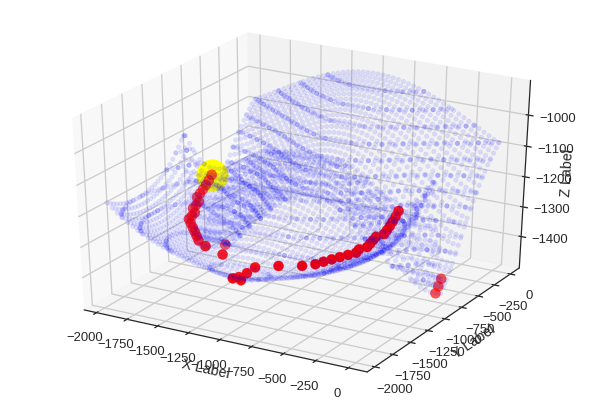

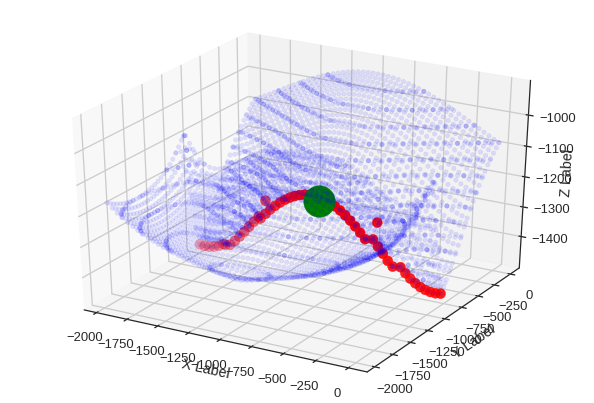

Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:143: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


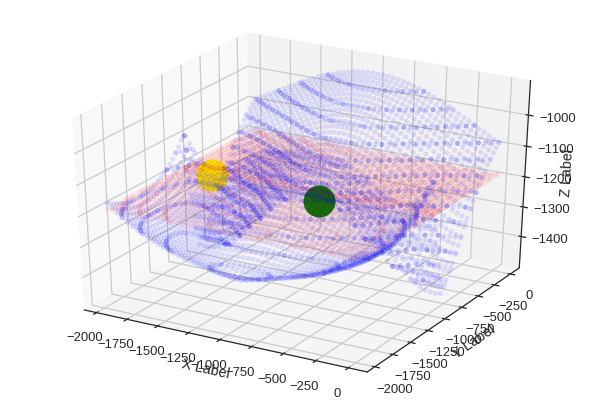

Bottom_Z: -1184.24453735
Maximum reservoir volume: 12160000.0 m³


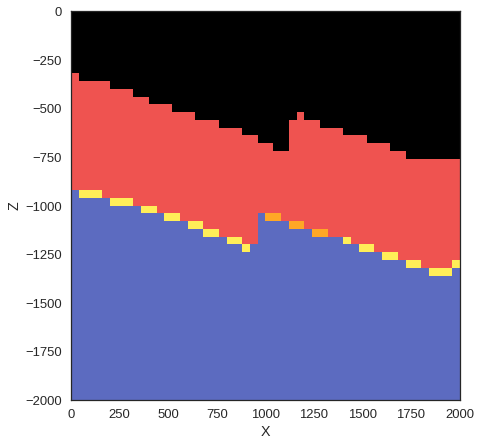

In [23]:
  
@pymc.deterministic
def model_unc_all(value=0, z_sec_res_top = z_sec_res_top, 
                  z_res_top = z_res_top, z_seal_top = z_seal_top, z_base_top = z_base_top):
    
    new_z_sec_res = sec_res_z + z_sec_res_top
    new_z_seal = seal_z + z_seal_top
    new_z_res = res_z + z_res_top
    new_z_base = base_z + z_base_top
    
    print('Z-Variations:', z_sec_res_top, z_seal_top, z_res_top, z_base_top)
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'] = new_z_sec_res
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z_seal
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'] = new_z_res
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'NonReservoirDeep'] = new_z_base
   
    sol, pot = gp.compute_model(interp_data, get_potential_at_interfaces=True)
    
    res_surf, what_surf = gp.get_surfaces(potential_block=sol[0, 1,:], 
                                          interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Reservoir']),)
    
    #print(sol[1,:])
    lith_block = sol[0, 0,:]
    fault_block = sol[0, 2,:]
    
    spill_z, spill_p, spill_line, spill_bottom = spill_point(res_surf)
    leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surf)
    
    print('Spill_Z:', spill_z)
    print('Leak_Z:', leak_z)
    
    plot_spill(res_surf, spill_line, spill_p)
    plot_leak(res_surf, leak_line, leak_p)
            
    max_vol, sol[0, 0,:], bottom = max_res_vol(lith_block, fault_block, res_surf)
    
    plot_trap(res_surf, bottom, spill_p, leak_p)
    print("Bottom_Z:", bottom[1,2])
    
    print("Maximum reservoir volume: %s m³" % max_vol)
    gp.plot_section(geo_data, sol[0, 0,:], 25)
    return sol

In [24]:
iterations = 5
model2 = pymc.Model([model_unc_all, z_sec_res_top, z_seal_top, z_res_top, z_base_top])

Z-Variations: 

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWa

-2.574720944564407e-05 -0.01472609044293142 0.04064745210537701 -0.019112350353771634
Spill_Z: -899.660797119
Leak_Z: -1000.0


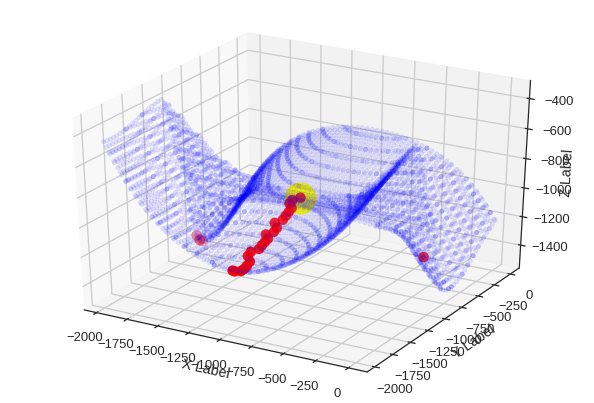

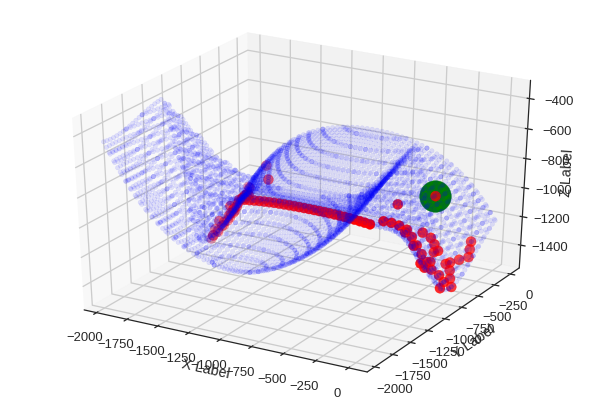

Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:143: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


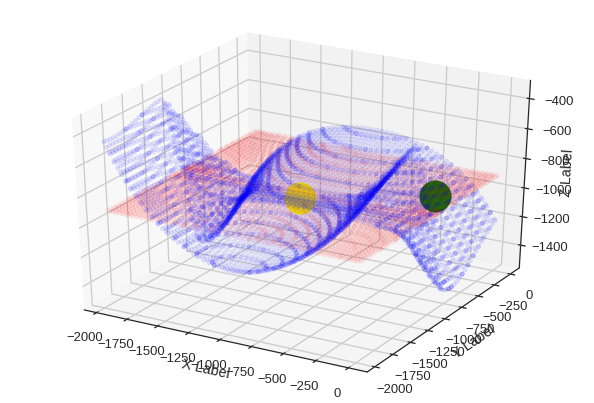

Bottom_Z: -899.660797119
Maximum reservoir volume: 203264000.0 m³
 [---------------  40%                  ] 2 of 5 complete in 31.7 secZ-Variations: -0.011788102251511248 -0.02086654095177432 0.04065036991269086 -0.1446779744669788
Spill_Z: -901.184158325
Leak_Z: -1000.0


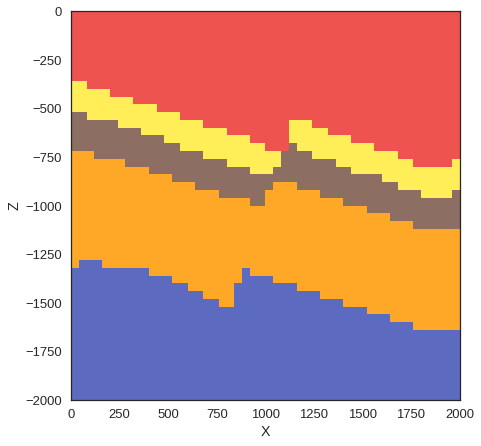

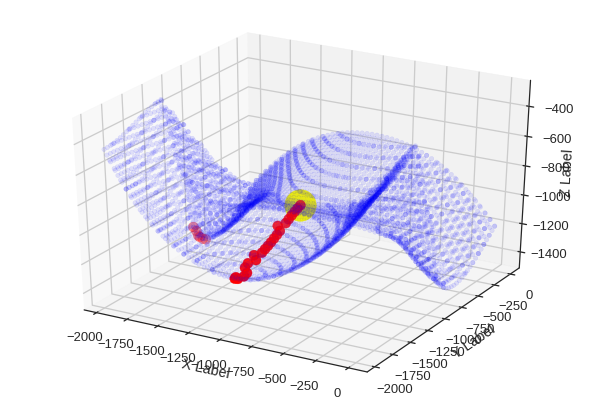

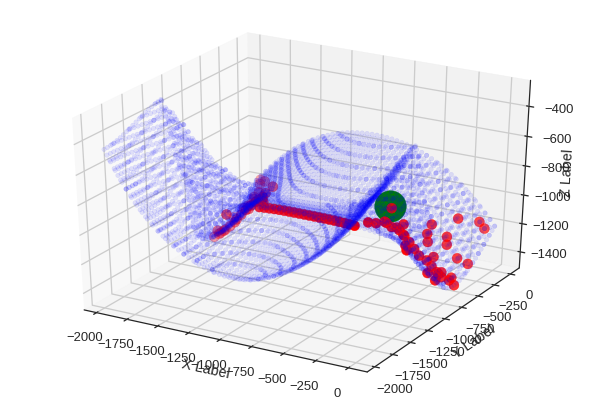

Down to spill.


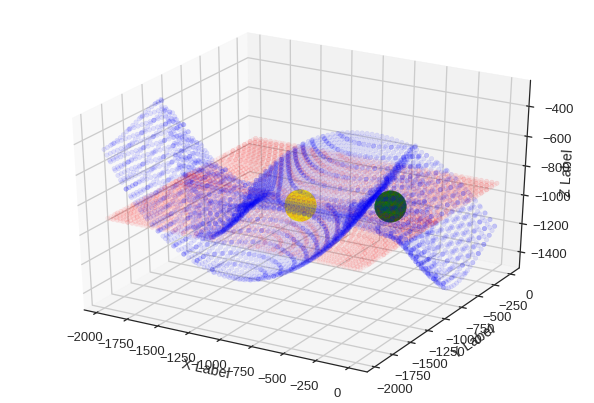

Bottom_Z: -901.184158325
Maximum reservoir volume: 212672000.0 m³
 [-----------------60%--                ] 3 of 5 complete in 63.7 secZ-Variations: -0.008465844314634744 0.008050085560785335 0.01884935383880439 -0.34902968844129156
Spill_Z: -1025.08735657
Leak_Z: -1016.59828186


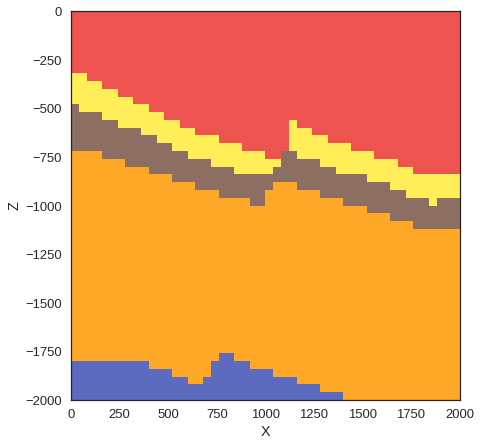

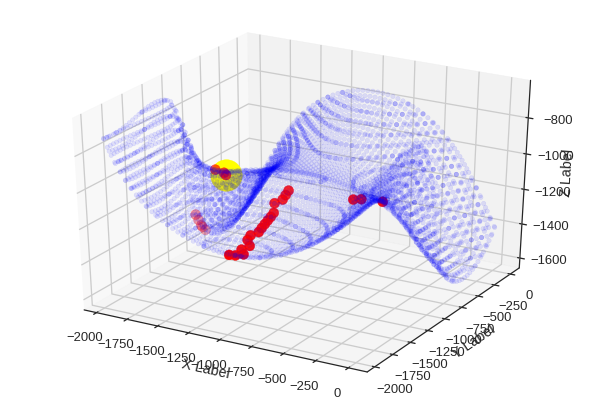

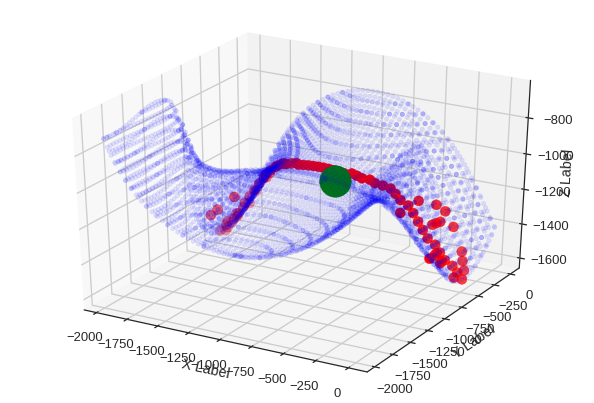

Down to leak.


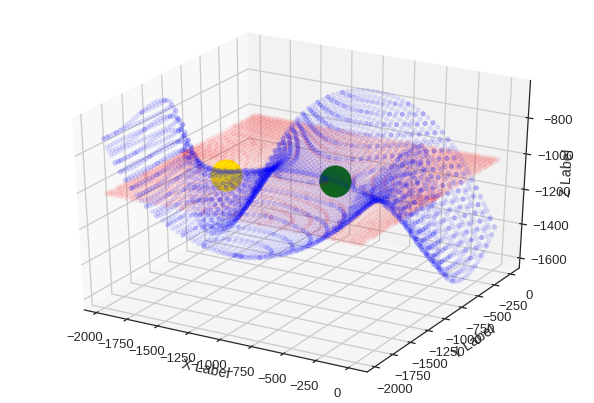

Bottom_Z: -1016.59828186
Maximum reservoir volume: 84800000.0 m³
 [-----------------80%----------        ] 4 of 5 complete in 93.8 secZ-Variations: 0.0030932264125547167

/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.253069092932435e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


 0.029163984740163833 -0.013994069521083187 -0.23774818161930453
Spill_Z: -1202.74917603
Leak_Z: -1189.96482849


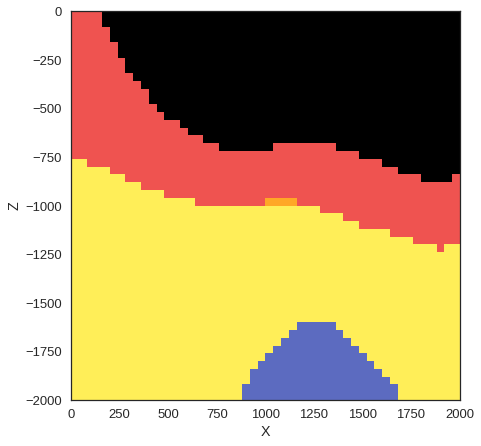

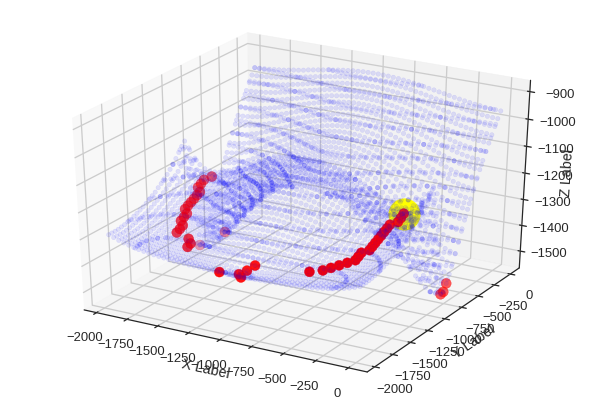

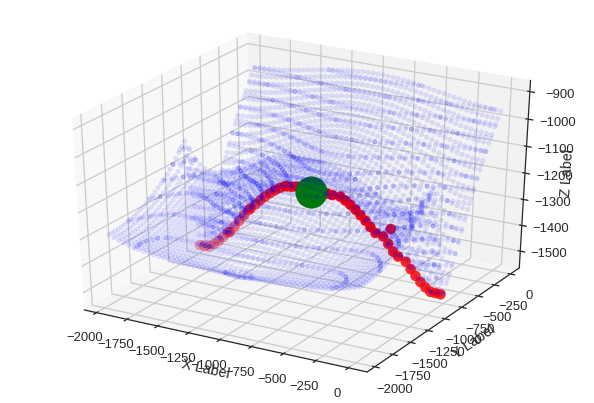

Down to leak.


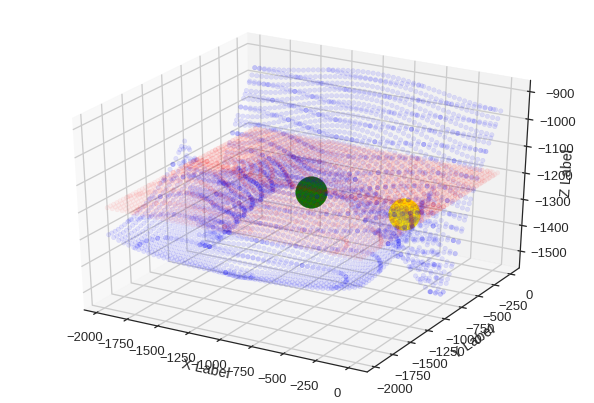

Bottom_Z: -1189.96482849
Maximum reservoir volume: 14656000.0 m³
 [-----------------100%-----------------] 5 of 5 complete in 119.0 secZ-Variations: 0.0043380154273279636 0.01060721466235554 -0.02020585363791179 0.14610128317188145
Spill_Z: -1194.53514099
Leak_Z: -1169.62272644


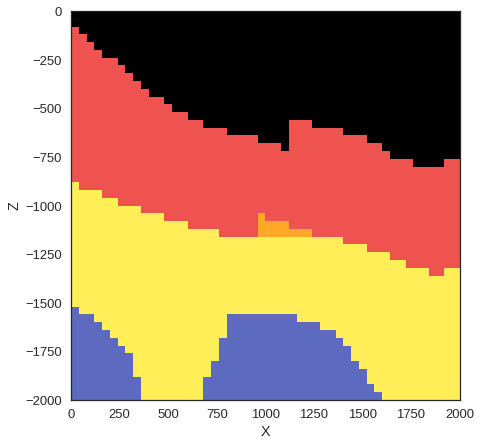

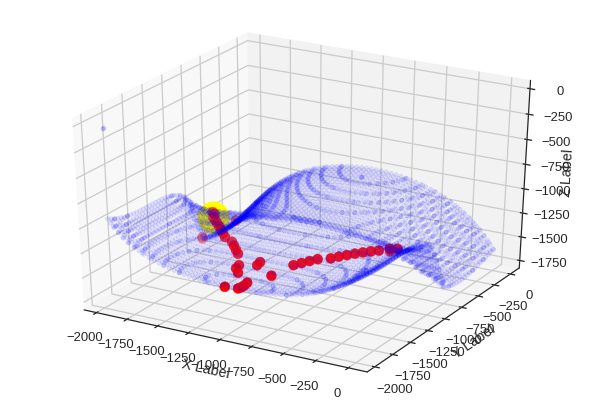

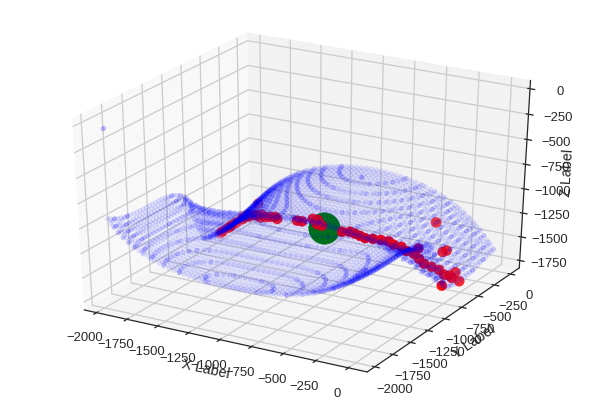

Down to leak.


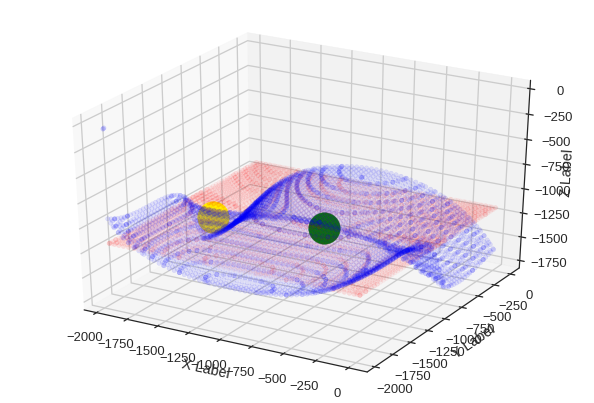

Bottom_Z: -1169.62272644
Maximum reservoir volume: 1818176000.0 m³
 [--------------------120%---------------------] 6 of 5 complete in 147.0 sec

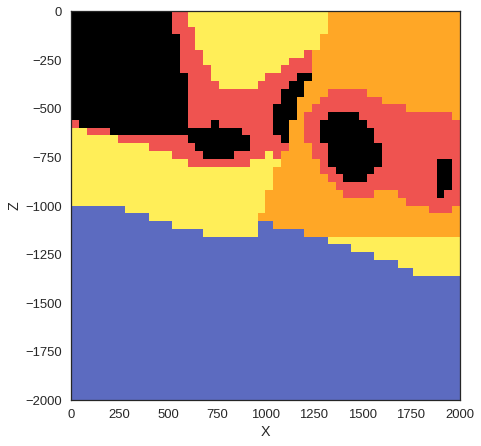

In [25]:
M2 = pymc.MCMC(model2)
M2.sample(iter=iterations)

In [72]:
sec_res_unc_trace = M2.trace('z_unc_sec_res')[:]
seal_unc_trace = M2.trace('z_unc_seal')[:]
res_unc_trace = M2.trace('z_unc_res')[:]
base_base_trace = M2.trace('z_unc_base')[:]
model2_trace = M2.trace('model_unc_all')[:]

for j in range(iterations):
    plt.figure()
    #plt.title('Change in res_top: %s' % bla[j])
    #print(bla[j])
    gp.plot_section(geo_data, model2_trace[j,0], 20)

ValueError: total size of new array must be unchanged

In [ ]:
max_z = -1112
sol[0,0,:] = set_spill_to_seal(geo_data, sol[0,0,:], max_z)

lith_spill = np.argmin(np.abs(geo_data.grid.grid[:, 2]+np.abs(max_z)))
bol_lith_spill = geo_data.grid.grid[:, 2] == geo_data.grid.grid[:, 2][lith_spill]
lith[bol_lith_spill] = 4


In [4]:
geo_data.grid?